In [66]:
import yfinance as yf
import datetime 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
import scipy.stats as stats
from outliers import smirnov_grubbs as grubbs
from pyod.models.hbos import HBOS
from sklearn.svm import OneClassSVM
from scipy.stats import shapiro
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from bs4 import BeautifulSoup
import re
from datetime import datetime, timedelta
import requests
import time

In [124]:
df = yf.download("ADANIENT.NS", start="2020-01-01", end="2021-05-20",group_by="ticker") 

[*********************100%***********************]  1 of 1 completed


In [125]:
df['Fluctuations'] = df['High'] - df['Low']
df['Daily Log Returns']=np.log(df['Close'])-np.log(df['Close'].shift(1))
df['Lag1']=(df['Close']-df['Close'].shift(1))
df['Lag2']=(df['Close']-df['Close'].shift(2))
df['Lag3']=(df['Close']-df['Close'].shift(3))
df['Lag4']=(df['Close']-df['Close'].shift(4))
df['Lag5']=(df['Close']-df['Close'].shift(5))
df.drop('Adj Close',axis=1,inplace=True)
df.drop('Open',axis=1,inplace=True)
df.reset_index(inplace=True)
df.tail()

,Date,High,Low,Close,Volume,Fluctuations,Daily Log Returns,Lag1,Lag2,Lag3,Lag4,Lag5
337,2021-05-12,1328.500000,1278.599976,1285.800049,4143731,49.900024,-0.013672,-17.699951,-18.299927,-13.099976,-0.949951,18.300049
338,2021-05-14,1302.000000,1213.349976,1220.349976,6377643,88.650024,-0.052243,-65.450073,-83.150024,-83.750000,-78.550049,-66.400024
339,2021-05-17,1299.000000,1227.449951,1289.099976,7782732,71.550049,0.054807,68.750000,3.299927,-14.400024,-15.000000,-9.800049
340,2021-05-18,1344.949951,1302.000000,1326.699951,6531595,42.949951,0.028750,37.599976,106.349976,40.899902,23.199951,22.599976
341,2021-05-19,1351.550049,1283.900024,1294.699951,9925284,67.650024,-0.024416,-32.000000,5.599976,74.349976,8.899902,-8.800049


We compare the percentage change of market (NIFTY50) and our target stock(ADANIENT) by taking ratio of daily returns percentage of both.

In [126]:
df1 = yf.download("^NSEI", start="2020-01-01", end="2021-05-20",group_by="ticker")
df1.reset_index(inplace=True)
df1['change'] = df1['Close'].pct_change()[1:]

df['change'] = df['Close'].pct_change()[1:]

df = df.merge(df1, left_on=['Date'], right_on=['Date'], how='right')

df['Change_wrt_market'] = df['change_x']/df['change_y']

df.drop(['change_x','Open', 'High_y', 'Low_y', 'Close_y', 'Adj Close', 'Volume_y','change_y'],axis=1,inplace=True)  
df.rename(columns={'High_x': 'High','Low_x': 'Low','Close_x': 'Close','Volume_x': 'Volume'},inplace=True)

[*********************100%***********************]  1 of 1 completed


C:\Users\karti\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


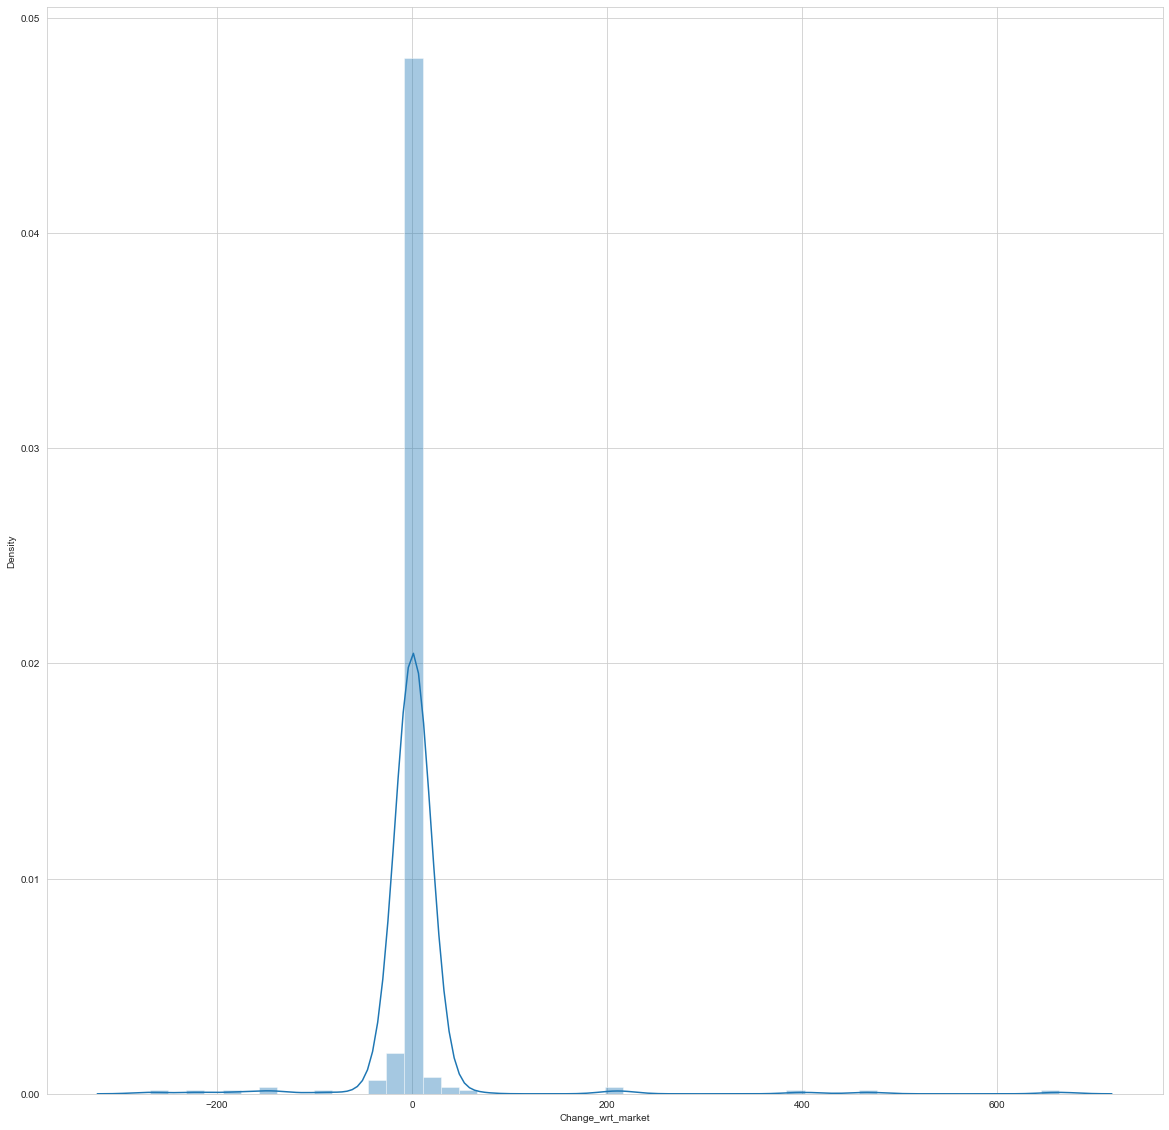

In [128]:
plt.figure(figsize=(20,20))
sns.set_style('whitegrid')
sns.distplot(df['Change_wrt_market'], bins=50, kde=True);

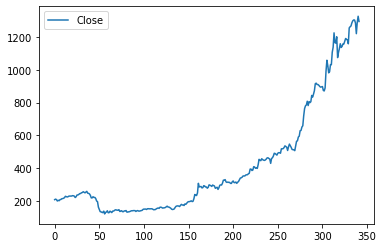

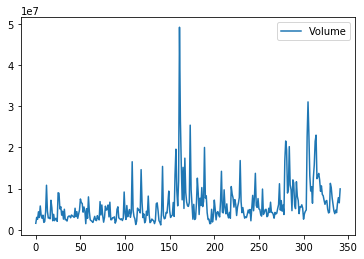

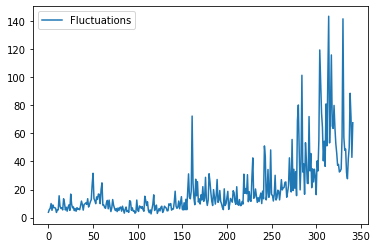

In [4]:
df.plot(y="Close")
df.plot(y="Volume")
df.plot(y="Fluctuations")

C:\Users\karti\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


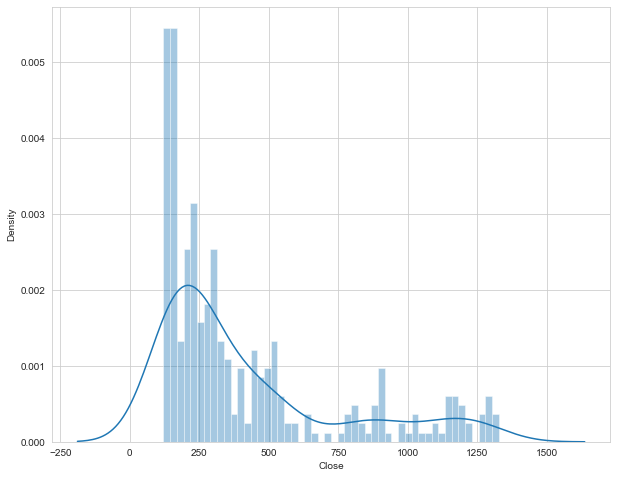

In [5]:
plt.figure(figsize=(10,8)) 
sns.set_style('whitegrid')
sns.distplot(df['Close'], bins=50, kde=True);

C:\Users\karti\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


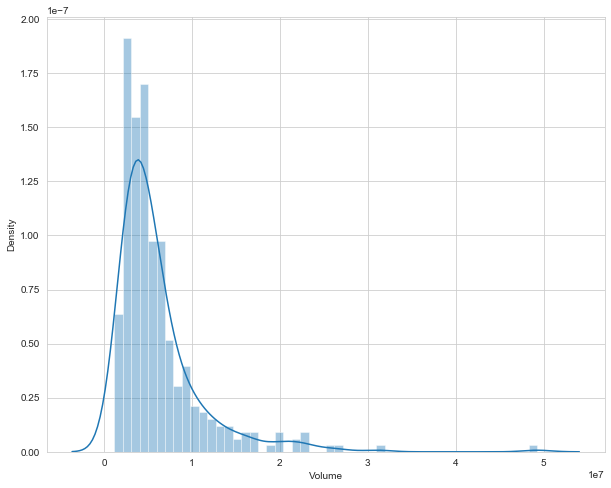

In [6]:
plt.figure(figsize=(10,8)) 
sns.set_style('whitegrid')
sns.distplot(df['Volume'], bins=50, kde=True);

C:\Users\karti\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


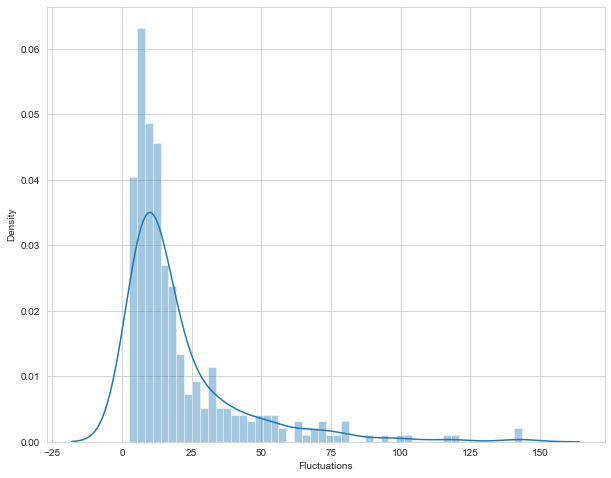

In [7]:
plt.figure(figsize=(10,8)) 
sns.set_style('whitegrid')
sns.distplot(df['Fluctuations'], bins=50, kde=True);

In [8]:
print(df['Daily Log Returns'].std()) # High volatile share

0.03508456250970592


In [129]:
def get_technical_indicators(dataset):
    # Create 21 days Moving Average
    dataset['ma21_Close'] = dataset['Close'].rolling(window=21).mean()
    dataset['ma7_Close'] = dataset['Close'].rolling(window=7).mean()

    # Create Bollinger Bands
    dataset['21sd'] = dataset['Close'].rolling(window=21).std()
    dataset['upper_band'] = dataset['ma21_Close'] + (dataset['21sd']*2)
    dataset['lower_band'] = dataset['ma21_Close'] - (dataset['21sd']*2)

    # Create MACD
    dataset['ema21_Close'] = dataset['Close'].ewm(span=21).mean()

    dataset.drop('21sd',axis=1,inplace=True)

    return dataset

df = get_technical_indicators(df)
df.head()

,Date,High,Low,Close,Volume,Fluctuations,Daily Log Returns,Lag1,Lag2,Lag3,Lag4,Lag5,Change_wrt_market,ma21_Close,ma7_Close,upper_band,lower_band,ema21_Close
0,2020-01-01,210.449997,206.649994,207.850006,1553127,3.800003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.850006
1,2020-01-02,213.199997,207.500000,211.199997,2991937,5.699997,0.015989,3.349991,NaN,NaN,NaN,NaN,1.969400,NaN,NaN,NaN,NaN,209.604763
2,2020-01-03,212.350006,205.800003,208.300003,2512421,6.550003,-0.013826,-2.899994,0.449997,NaN,NaN,NaN,3.035965,NaN,NaN,NaN,NaN,209.127797
3,2020-01-06,207.750000,197.750000,199.550003,4353179,10.000000,-0.042915,-8.750000,-11.649994,-8.300003,NaN,NaN,2.198631,NaN,NaN,NaN,NaN,206.380965
4,2020-01-07,205.699997,200.550003,204.050003,2966120,5.149994,0.022300,4.500000,-4.250000,-7.149994,-3.800003,NaN,4.515031,NaN,NaN,NaN,NaN,205.821964


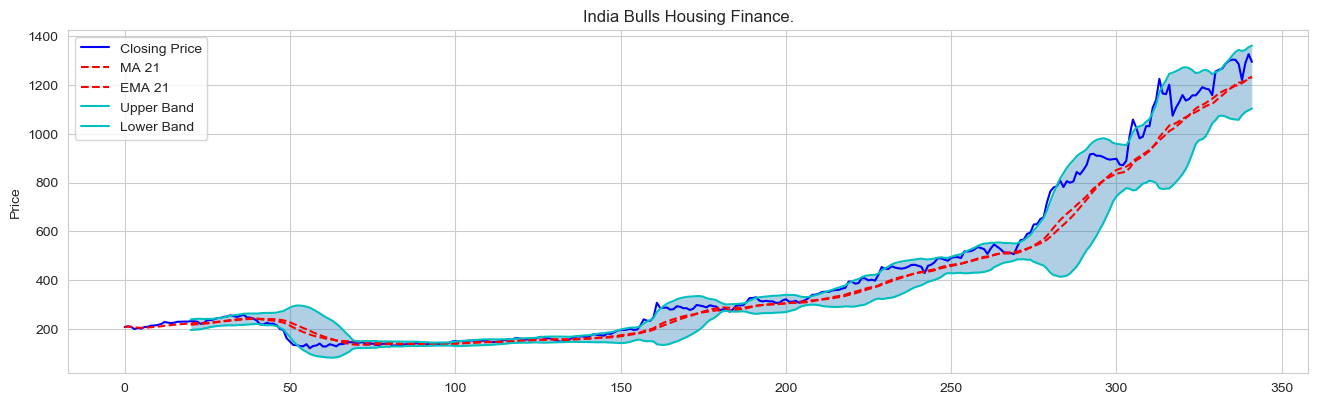

In [10]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    plt.subplot(2, 1, 1)
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21_Close'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['ema21_Close'],label='EMA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('India Bulls Housing Finance.')
    plt.ylabel('Price')
    plt.legend()  
   
    plt.show()
    
plot_technical_indicators(df, 365)

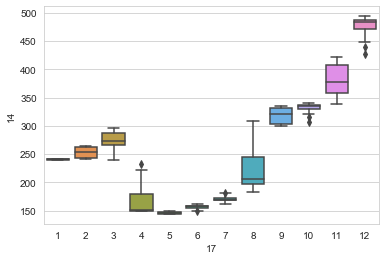

In [11]:
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df1 = pd.DataFrame()
df2 = pd.DataFrame()
df1=pd.DataFrame(df[df['Year']== 2020].values.tolist()) 
df2=pd.DataFrame(df[df['Year']== 2021].values.tolist())
sns.boxplot(x=df1[17],y=df1[14])        # 17th column is month and 14th column is 7 days moving average
df1.head()
df.drop('Month', axis=1, inplace=True)
df.drop('Year', axis=1, inplace=True)

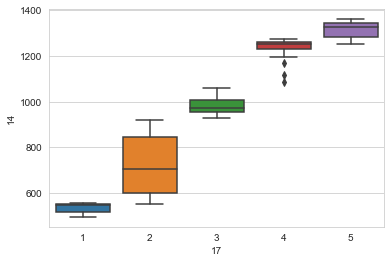

In [12]:
sns.boxplot(x=df2[17],y=df2[14])

In [130]:
df11=pd.DataFrame()
df11=pd.DataFrame(df[(df['Close']>df['upper_band']) | (df['Close']<df['lower_band'])].values.tolist())
df.drop('upper_band',axis=1,inplace=True)
df.drop('lower_band',axis=1,inplace=True)
df11.shape[0]

53

In [131]:
def get_technical_indicators(dataset):
    # Create 21 days Moving Average
    dataset['ma21_Volume'] = dataset['Volume'].rolling(window=21).mean()

    # Create Bollinger Bands
    dataset['21sd'] = dataset['Volume'].rolling(window=21).std()
    dataset['upper_band'] = dataset['ma21_Volume'] + (dataset['21sd']*2)
    dataset['lower_band'] = dataset['ma21_Volume'] - (dataset['21sd']*2)

    # Create MACD
    dataset['ema21_Volume'] = dataset['Volume'].ewm(span=21).mean()

    dataset.drop('21sd',axis=1,inplace=True)

    return dataset

df = get_technical_indicators(df)
df.head()

,Date,High,Low,Close,Volume,Fluctuations,Daily Log Returns,Lag1,Lag2,Lag3,Lag4,Lag5,Change_wrt_market,ma21_Close,ma7_Close,ema21_Close,ma21_Volume,upper_band,lower_band,ema21_Volume
0,2020-01-01,210.449997,206.649994,207.850006,1553127,3.800003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.850006,NaN,NaN,NaN,1.553127e+06
1,2020-01-02,213.199997,207.500000,211.199997,2991937,5.699997,0.015989,3.349991,NaN,NaN,NaN,NaN,1.969400,NaN,NaN,209.604763,NaN,NaN,NaN,2.306789e+06
2,2020-01-03,212.350006,205.800003,208.300003,2512421,6.550003,-0.013826,-2.899994,0.449997,NaN,NaN,NaN,3.035965,NaN,NaN,209.127797,NaN,NaN,NaN,2.381960e+06
3,2020-01-06,207.750000,197.750000,199.550003,4353179,10.000000,-0.042915,-8.750000,-11.649994,-8.300003,NaN,NaN,2.198631,NaN,NaN,206.380965,NaN,NaN,NaN,2.947289e+06
4,2020-01-07,205.699997,200.550003,204.050003,2966120,5.149994,0.022300,4.500000,-4.250000,-7.149994,-3.800003,NaN,4.515031,NaN,NaN,205.821964,NaN,NaN,NaN,2.951805e+06


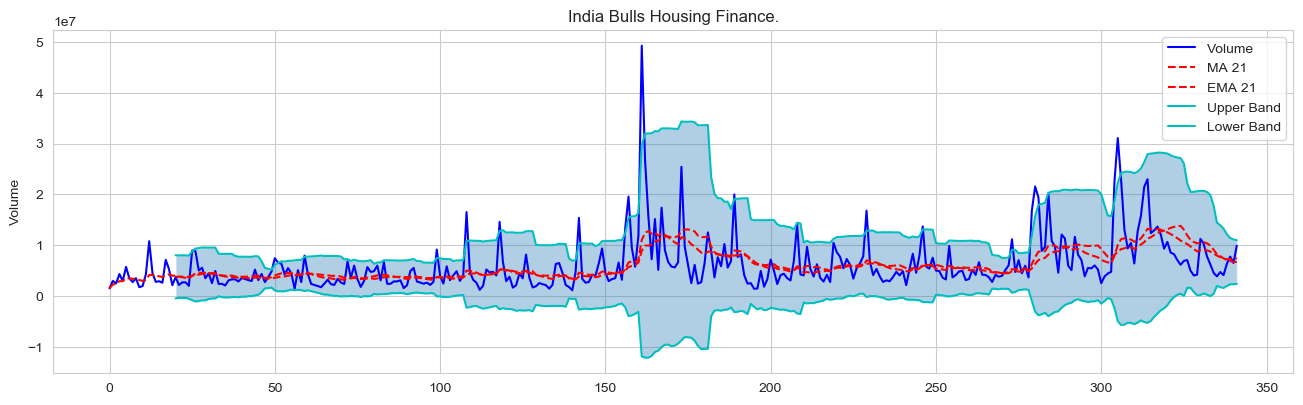

In [15]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    plt.subplot(2, 1, 1)
    plt.plot(dataset['Volume'],label='Volume', color='b')
    plt.plot(dataset['ma21_Volume'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['ema21_Volume'],label='EMA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('India Bulls Housing Finance.')
    plt.ylabel('Volume')
    plt.legend()  
   
    plt.show()
    
plot_technical_indicators(df, 365)

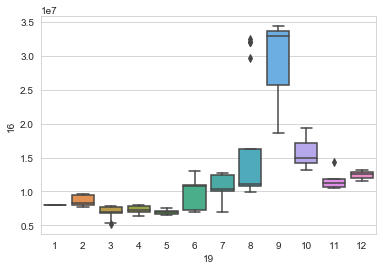

In [16]:
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df1 = pd.DataFrame()
df2 = pd.DataFrame()
df1=pd.DataFrame(df[df['Year']== 2020].values.tolist()) 
df2=pd.DataFrame(df[df['Year']== 2021].values.tolist())
sns.boxplot(x=df1[19],y=df1[16])        # 19th column is month and 16th column is 21 days moving average
df1.head()
df.drop('Month', axis=1, inplace=True)
df.drop('Year', axis=1, inplace=True)

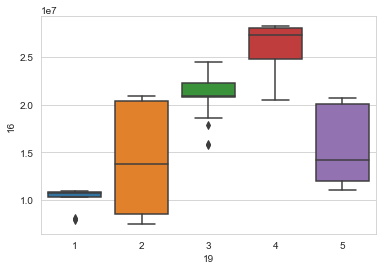

In [17]:
sns.boxplot(x=df2[19],y=df2[16])

In [132]:
df21=pd.DataFrame()
df21=pd.DataFrame(df[(df['Volume']>df['upper_band']) | (df['Volume']<df['lower_band'])].values.tolist())
df.drop('upper_band',axis=1,inplace=True)
df.drop('lower_band',axis=1,inplace=True)
df21.shape[0]

20

In [133]:
def get_technical_indicators(dataset):
    # Create 21 days Moving Average
    dataset['ma21_Fluctuations'] = dataset['Fluctuations'].rolling(window=21).mean()

    # Create Bollinger Bands
    dataset['21sd'] = dataset['Fluctuations'].rolling(window=21).std()
    dataset['upper_band'] = dataset['ma21_Fluctuations'] + (dataset['21sd']*2)
    dataset['lower_band'] = dataset['ma21_Fluctuations'] - (dataset['21sd']*2)

    # Create MACD
    dataset['ema21_Fluctuations'] = dataset['Fluctuations'].ewm(span=21).mean()

    dataset.drop('21sd',axis=1,inplace=True)

    return dataset

df = get_technical_indicators(df)
df.head()

,Date,High,Low,Close,Volume,Fluctuations,Daily Log Returns,Lag1,Lag2,Lag3,...,Change_wrt_market,ma21_Close,ma7_Close,ema21_Close,ma21_Volume,ema21_Volume,ma21_Fluctuations,upper_band,lower_band,ema21_Fluctuations
0,2020-01-01,210.449997,206.649994,207.850006,1553127,3.800003,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,207.850006,NaN,1.553127e+06,NaN,NaN,NaN,3.800003
1,2020-01-02,213.199997,207.500000,211.199997,2991937,5.699997,0.015989,3.349991,NaN,NaN,...,1.969400,NaN,NaN,209.604763,NaN,2.306789e+06,NaN,NaN,NaN,4.795238
2,2020-01-03,212.350006,205.800003,208.300003,2512421,6.550003,-0.013826,-2.899994,0.449997,NaN,...,3.035965,NaN,NaN,209.127797,NaN,2.381960e+06,NaN,NaN,NaN,5.436708
3,2020-01-06,207.750000,197.750000,199.550003,4353179,10.000000,-0.042915,-8.750000,-11.649994,-8.300003,...,2.198631,NaN,NaN,206.380965,NaN,2.947289e+06,NaN,NaN,NaN,6.745422
4,2020-01-07,205.699997,200.550003,204.050003,2966120,5.149994,0.022300,4.500000,-4.250000,-7.149994,...,4.515031,NaN,NaN,205.821964,NaN,2.951805e+06,NaN,NaN,NaN,6.362813


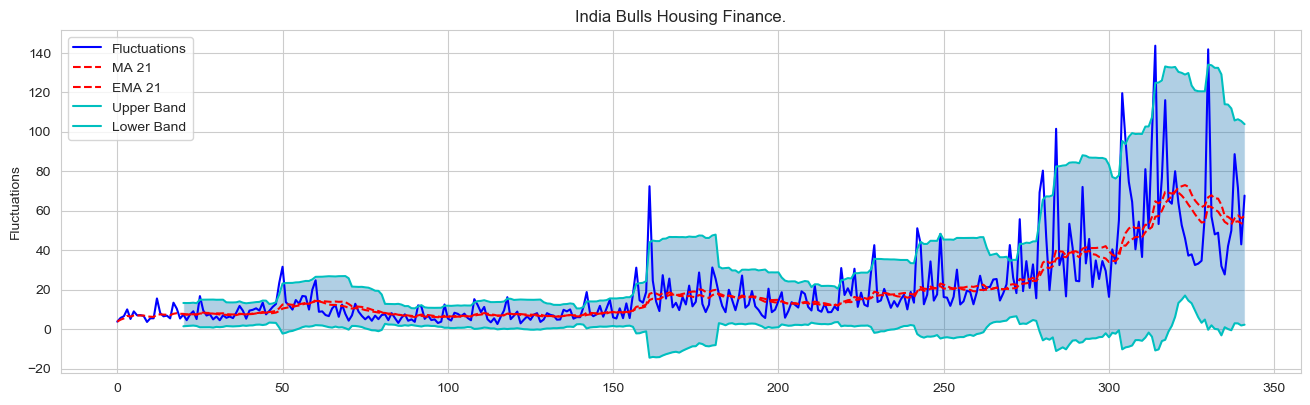

In [20]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    plt.subplot(2, 1, 1)
    plt.plot(dataset['Fluctuations'],label='Fluctuations', color='b')
    plt.plot(dataset['ma21_Fluctuations'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['ema21_Fluctuations'],label='EMA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('India Bulls Housing Finance.')
    plt.ylabel('Fluctuations')
    plt.legend()  
   
    plt.show()
    
plot_technical_indicators(df, 365)

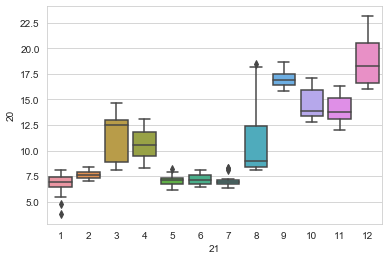

In [21]:
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df1 = pd.DataFrame()
df2 = pd.DataFrame()
df1=pd.DataFrame(df[df['Year']== 2020].values.tolist()) 
df2=pd.DataFrame(df[df['Year']== 2021].values.tolist())
sns.boxplot(x=df1[21],y=df1[20])        # 17th column is month and 15th column is 21 days moving average
df1.head()
df.drop('Month', axis=1, inplace=True)
df.drop('Year', axis=1, inplace=True)

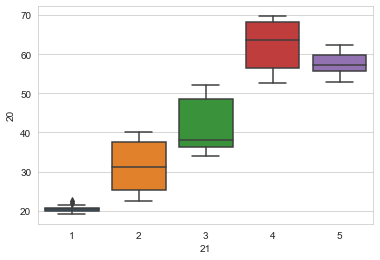

In [22]:
sns.boxplot(x=df2[21],y=df2[20])

In [134]:
df31=pd.DataFrame()
df31=pd.DataFrame(df[(df['Fluctuations']>df['upper_band']) | (df['Fluctuations']<df['lower_band'])].values.tolist())
df.drop('upper_band',axis=1,inplace=True)
df.drop('lower_band',axis=1,inplace=True)
df31.shape[0]

24

In [135]:
#momentum based oscillator to determine the price current trend w.r.t to previous trends
df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3 
df['sma'] = df['TP'].rolling(21).mean()
df['mad'] = df['TP'].rolling(21).apply(lambda x: pd.Series(x).mad())
df['CCI'] = (df['TP'] - df['sma']) / (0.015 * df['mad']) 
df.drop('High',axis=1,inplace=True)
df.drop('Low',axis=1,inplace=True)
df.drop('TP',axis=1,inplace=True)
df.drop('sma',axis=1,inplace=True)
df.drop('mad',axis=1,inplace=True)
df.head()

,Date,Close,Volume,Fluctuations,Daily Log Returns,Lag1,Lag2,Lag3,Lag4,Lag5,Change_wrt_market,ma21_Close,ma7_Close,ema21_Close,ma21_Volume,ema21_Volume,ma21_Fluctuations,ema21_Fluctuations,CCI
0,2020-01-01,207.850006,1553127,3.800003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.850006,NaN,1.553127e+06,NaN,3.800003,NaN
1,2020-01-02,211.199997,2991937,5.699997,0.015989,3.349991,NaN,NaN,NaN,NaN,1.969400,NaN,NaN,209.604763,NaN,2.306789e+06,NaN,4.795238,NaN
2,2020-01-03,208.300003,2512421,6.550003,-0.013826,-2.899994,0.449997,NaN,NaN,NaN,3.035965,NaN,NaN,209.127797,NaN,2.381960e+06,NaN,5.436708,NaN
3,2020-01-06,199.550003,4353179,10.000000,-0.042915,-8.750000,-11.649994,-8.300003,NaN,NaN,2.198631,NaN,NaN,206.380965,NaN,2.947289e+06,NaN,6.745422,NaN
4,2020-01-07,204.050003,2966120,5.149994,0.022300,4.500000,-4.250000,-7.149994,-3.800003,NaN,4.515031,NaN,NaN,205.821964,NaN,2.951805e+06,NaN,6.362813,NaN


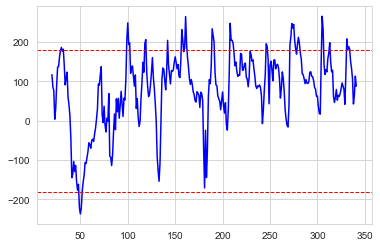

In [25]:
plt.plot(df['CCI'], color = 'blue')
plt.axhline(180, linestyle = '--', linewidth = 1, color = 'red')
plt.axhline(-180, linestyle = '--', linewidth = 1, color = 'red')
plt.show()

In [136]:
df12=pd.DataFrame()
df12=pd.DataFrame(df[(df['CCI']>180) | (df['CCI']<-180)].values.tolist())
df12.shape[0]

43

In [137]:
print(pd.merge(df11, df12, on=0).shape[0]) 
df12.set_index(0,inplace=True)
df11_12 = pd.concat([df11,df12]).reset_index()
df11_12=df11_12.drop_duplicates(subset=0)
df11_12.shape[0]

35


54

In [138]:
df12.reset_index(0,inplace=True)
df21.reset_index(0,inplace=True)
df31.reset_index(0,inplace=True)

dmerge1 = pd.merge(df11_12, df21, on=0)
dmerge2 = pd.merge(df31, df21, on=0)
dmerge1.set_index(0,inplace=True)
dmerge2.set_index(0,inplace=True)
do1 = pd.concat([dmerge1,dmerge2]).reset_index()
do1 = do1.drop_duplicates(subset=0)
print(do1.shape[0])
do1.head()

18


,0,index_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,...,14_y,15_y,16_y,17_y,18_y,19,19_x,20,21,19_y
0,2020-03-13,7,161.350006,129.750000,148.750000,7463176.0,31.600006,-0.086255,-13.399994,-47.000000,...,194.850000,213.862019,3.631099e+06,6.115018e+06,1.147180e+06,4.071253e+06,NaN,NaN,NaN,NaN
1,2020-03-16,8,142.300003,128.649994,134.699997,6582749.0,13.650009,-0.099217,-14.050003,-27.449997,...,182.507141,206.614448,3.730739e+06,6.509759e+06,9.517181e+05,4.301189e+06,NaN,NaN,NaN,NaN
2,2020-05-29,10,153.600006,141.100006,148.350006,9162612.0,12.500000,0.039180,5.700012,7.350006,...,141.321431,140.672999,3.731488e+06,7.502384e+06,-3.940687e+04,3.769610e+06,NaN,NaN,NaN,NaN
3,2020-06-25,12,169.199997,153.000000,161.649994,14608370.0,16.199997,0.043299,6.849991,4.449997,...,153.714284,150.851161,5.119106e+06,1.282490e+07,-2.586689e+06,5.230285e+06,NaN,NaN,NaN,NaN
4,2020-07-29,15,190.850006,172.050003,179.100006,15392378.0,18.800003,0.031479,5.550003,13.150009,...,170.571429,163.147623,3.855587e+06,1.036905e+07,-2.657872e+06,4.616538e+06,NaN,NaN,NaN,NaN


In [139]:
x=pd.DataFrame(df[['Close','Volume','Fluctuations']])
clf=IsolationForest(n_estimators=100, max_samples='auto', \
                        max_features=x.shape[1], bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(x)
pred = clf.predict(x)
df['anomaly']=pred
outliers=df.loc[df['anomaly']==-1]
df1233=pd.DataFrame()
df1233=pd.DataFrame(outliers.values.tolist())
df.drop('anomaly',axis=1,inplace=True)
df1233.shape

C:\Users\karti\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
C:\Users\karti\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\Users\karti\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


(34, 20)

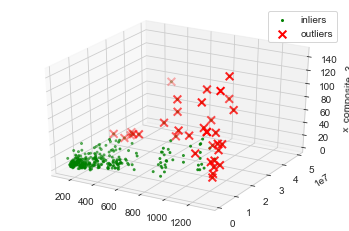

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")

ax.scatter(df['Close'], df['Volume'], zs=df['Fluctuations'], s=4, lw=1, label="inliers",c="green")

ax.scatter(df1233[1],df1233[2], df1233[3],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

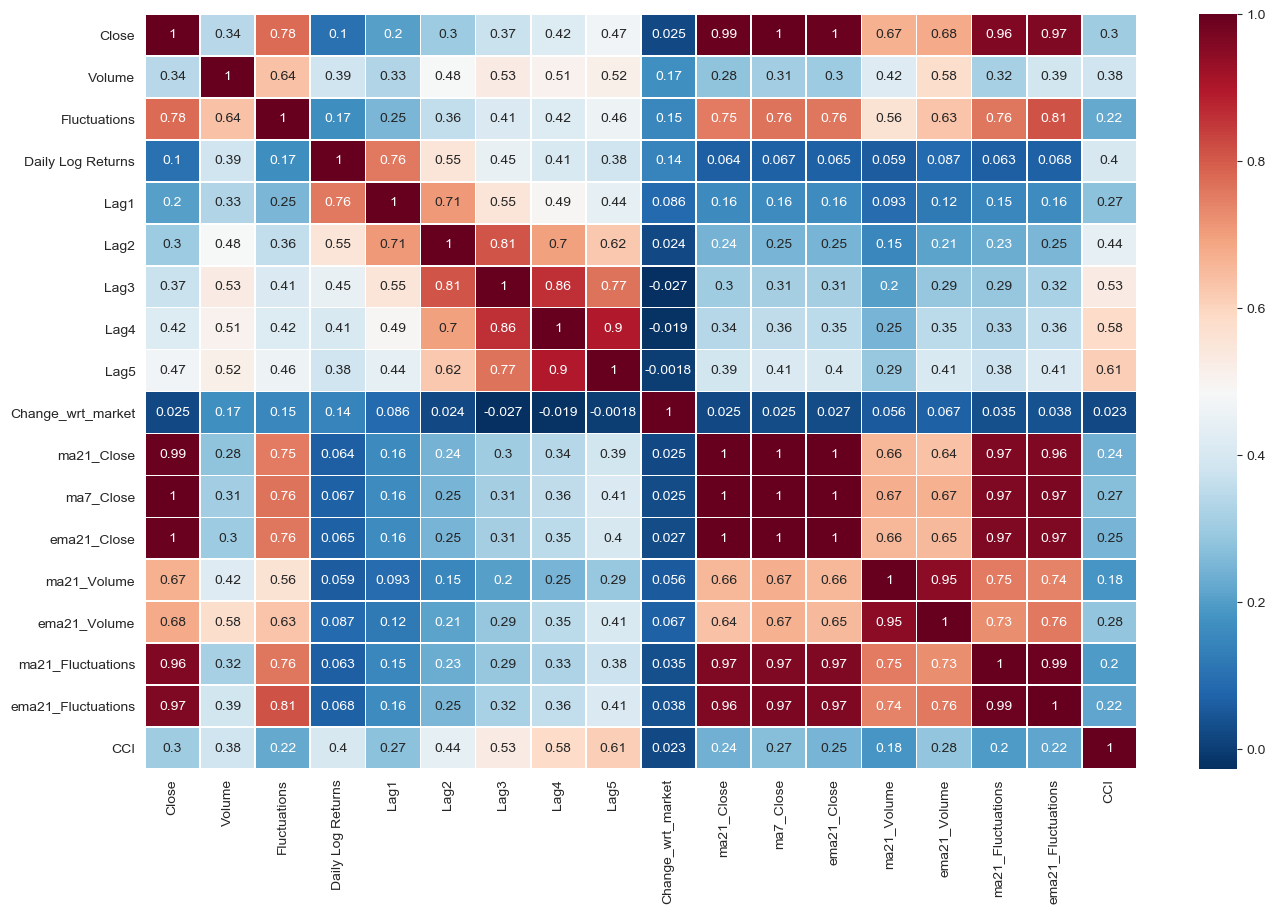

In [140]:
corr = df.corr()
plt.figure(figsize=(16, 10), dpi=100)
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns,cmap='RdBu_r',annot=True,linewidth=0.5)

C:\Users\karti\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


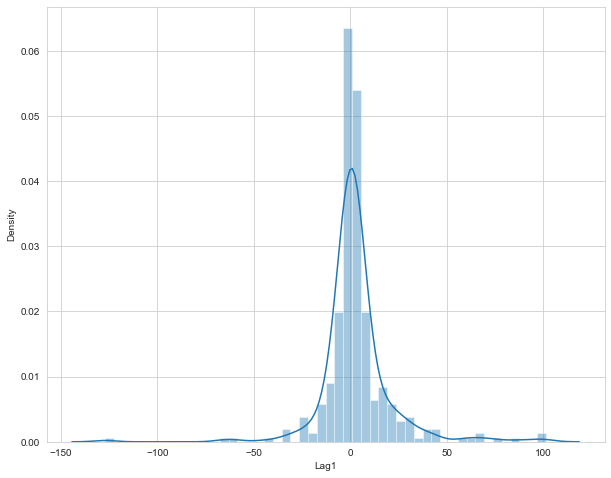

In [32]:
plt.figure(figsize=(10,8)) 
sns.set_style('whitegrid')
sns.distplot(df['Lag1'], bins=50, kde=True);

In [33]:
shapiro(df['Lag1'])

(nan, 1.0)

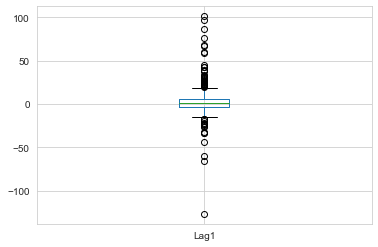

In [34]:
df['Lag1'].plot(kind='box')

In [141]:
global df47
df47 = []
def test_stat(y, iteration):
    std_dev = np.std(y)
    avg_y = np.mean(y)
    abs_val_minus_avg = abs(y - avg_y)
    max_of_deviations = max(abs_val_minus_avg)
    max_ind = np.argmax(abs_val_minus_avg)
    cal = max_of_deviations/ std_dev
    print('Test {}'.format(iteration))
    print("Test Statistics Value(R{}) : {}".format(iteration,cal))
    return cal, max_ind

def calculate_critical_value(size, alpha, iteration):
    t_dist = stats.t.ppf(1 - alpha / (2 * size), size - 2)
    numerator = (size - 1) * np.sqrt(np.square(t_dist))
    denominator = np.sqrt(size) * np.sqrt(size - 2 + np.square(t_dist))
    critical_value = numerator / denominator
    print("Critical Value(λ{}): {}".format(iteration, critical_value))
    return critical_value

def check_values(R, C, inp, max_index, iteration):
    if R > C:
        print('{} is an outlier. R{} > λ{}: {:.4f} > {:.4f} \n'.format(inp[max_index],iteration, iteration, R, C))
        df47.append(inp[max_index])
    else:
        print('{} is not an outlier. R{}> λ{}: {:.4f} > {:.4f} \n'.format(inp[max_index],iteration, iteration, R, C))

def ESD_Test(input_series, alpha, max_outliers):
    stats = []
    critical_vals = []
    for iterations in range(1, max_outliers + 1):
        stat, max_index = test_stat(input_series, iterations)
        critical = calculate_critical_value(len(input_series), alpha, iterations)
        check_values(stat, critical, input_series, max_index, iterations)
        input_series = np.delete(input_series, max_index)
        critical_vals.append(critical)
        stats.append(stat)
        if stat > critical:
            max_i = iterations
    print('H0:  there are no outliers in the data')
    print('Ha:  there are up to 10 outliers in the data')
    print('')
    print('Significance level:  α = {}'.format(alpha))
    print('Critical region:  Reject H0 if Ri > critical value')
    print('Ri: Test statistic')
    print('λi: Critical Value')
    print(' ')

x=np.array(df['Lag1'])
ESD_Test(x, 0.05, 30)

Test 1
Test Statistics Value(R1) : nan
Critical Value(λ1): 3.7594263142134867
nan is not an outlier. R1> λ1: nan > 3.7594 

Test 2
Test Statistics Value(R2) : 7.054645248682345
Critical Value(λ2): 3.758610862817888
-127.0 is an outlier. R2 > λ2: 7.0546 > 3.7586 

Test 3
Test Statistics Value(R3) : 5.733274847051893
Critical Value(λ3): 3.7577926883926085
101.39996337890625 is an outlier. R3 > λ3: 5.7333 > 3.7578 

Test 4
Test Statistics Value(R4) : 5.762953752073624
Critical Value(λ4): 3.7569717734200845
96.85009765625 is an outlier. R4 > λ4: 5.7630 > 3.7570 

Test 5
Test Statistics Value(R5) : 5.450652713035063
Critical Value(λ5): 3.7561481002159676
87.1500244140625 is an outlier. R5 > λ5: 5.4507 > 3.7561 

Test 6
Test Statistics Value(R6) : 4.965629661596059
Critical Value(λ6): 3.755321650927375
76.0499267578125 is an outlier. R6 > λ6: 4.9656 > 3.7553 

Test 7
Test Statistics Value(R7) : 4.774766410434697
Critical Value(λ7): 3.754492407531229
-65.4500732421875 is an outlier. R7 > λ7: 

In [142]:
df47 = pd.DataFrame(df47)
df47.shape

(12, 1)

In [143]:
df47.rename(columns={0:'Lag1'}, inplace=True)
df47 = pd.merge(df, df47, on='Lag1')
df47.shape

(12, 19)

In [144]:
min_max_scaler = MinMaxScaler()
x=pd.DataFrame(df[['Close','Volume','Fluctuations']])
x[["Close", "Volume", "Fluctuations"]] = min_max_scaler.fit_transform(x[["Close", "Volume", "Fluctuations"]])
model = DBSCAN(eps = 0.15, min_samples = 6).fit(x)
print(model.labels_)

C:\Users\karti\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  0  0 -1  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  0  0  0  0  0  0
 -1 -1  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0

In [145]:
df['anomaly'] = model.labels_
df1234=pd.DataFrame()
df1234=pd.DataFrame(df[df['anomaly']==-1])
df.drop('anomaly', axis=1, inplace =True)
df1234.shape[0]

12

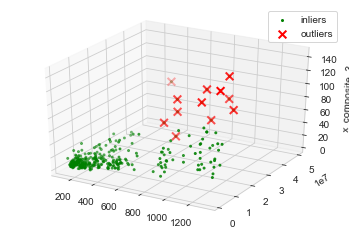

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")

ax.scatter(df['Close'], df['Volume'], zs=df['Fluctuations'], s=4, lw=1, label="inliers",c="green")

ax.scatter(df1234['Close'],df1234['Volume'], df1234['Fluctuations'],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

In [146]:
x=pd.DataFrame(df[['Close','Volume','Fluctuations','Lag1', 'Lag2', 'Lag3','Lag4','Lag5']])
x[['Close','Volume','Fluctuations','Lag1', 'Lag2', 'Lag3','Lag4','Lag5']] = min_max_scaler.fit_transform(x[['Close','Volume','Fluctuations','Lag1', 'Lag2', 'Lag3','Lag4','Lag5']])
hbos = HBOS(n_bins=100)
x=x.fillna(x.mode().iloc[0])
hbos.fit(x)
output = hbos.decision_function(x)

C:\Users\karti\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [147]:
df['anomaly'] = hbos.predict(x)
dfo2=pd.DataFrame()
dfo2=pd.DataFrame(df[df['anomaly']==1])
df.drop('anomaly', axis=1, inplace =True)
dfo2.shape[0]

34

In [148]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(dfo2)

          Date        Close    Volume  Fluctuations  Daily Log Returns  \
49  2020-03-12   162.149994   4834390     23.449997          -0.188317   
50  2020-03-13   148.750000   7463176     31.600006          -0.086255   
157 2020-08-19   239.550003  19592028     31.149994           0.114189   
161 2020-08-25   307.549988  49264537     72.399994           0.212390   
189 2020-10-05   326.600006  20009492     27.149994           0.058150   
242 2020-12-21   429.200012   5350194     51.100006          -0.058704   
272 2021-02-04   589.700012  11184167     55.700012           0.039960   
274 2021-02-08   628.299988   7085276     34.450012           0.053868   
276 2021-02-10   650.700012   5991927     32.800049           0.032567   
278 2021-02-12   718.950012  16810897     69.250000           0.087675   
279 2021-02-15   763.450012  21579566     80.299988           0.060056   
280 2021-02-16   780.200012  19426061     46.700012           0.021703   
287 2021-02-25   843.500000  12118095 

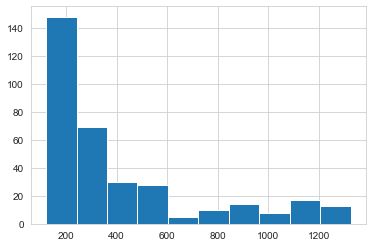

In [44]:
df['Close'].hist()

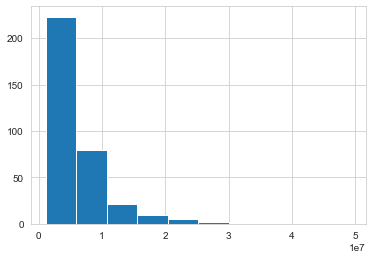

In [45]:
df['Volume'].hist()

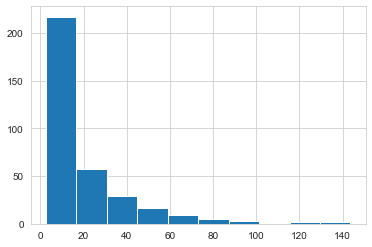

In [46]:
df['Fluctuations'].hist()

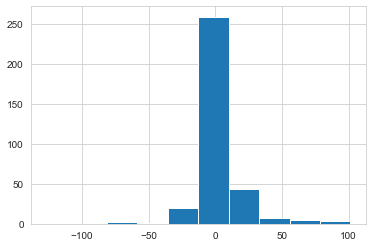

In [47]:
df['Lag1'].hist()

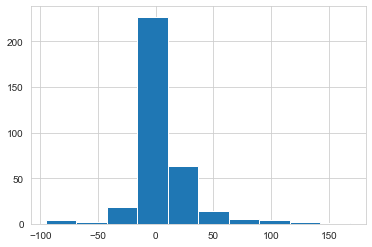

In [48]:
df['Lag2'].hist()

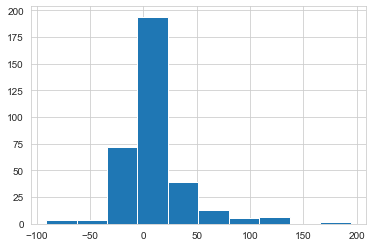

In [49]:
df['Lag3'].hist()

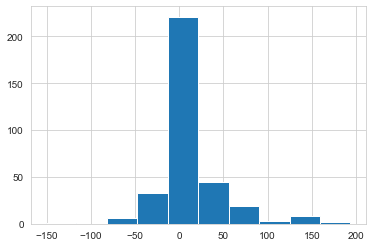

In [50]:
df['Lag4'].hist()

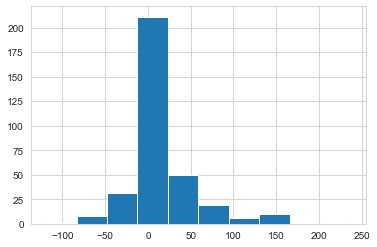

In [51]:
df['Lag5'].hist()

In [149]:
clf = LocalOutlierFactor(n_neighbors=2)
x=pd.DataFrame(df[['Close','Volume','Fluctuations']])
x[["Close", "Volume", "Fluctuations"]] = min_max_scaler.fit_transform(x[["Close", "Volume", "Fluctuations"]])
x=np.array(x)
df['anomaly'] = clf.fit_predict(x)
df1236=pd.DataFrame(df[df['anomaly']==-1])
df.drop('anomaly', axis=1, inplace =True)
df1236.shape

C:\Users\karti\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\karti\anaconda3\lib\site-packages\sklearn\neighbors\lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


(34, 20)

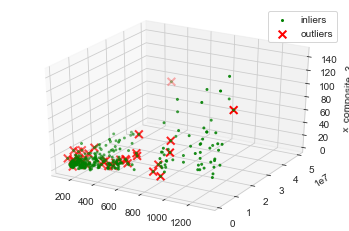

In [53]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")

ax.scatter(df['Close'], df['Volume'], zs=df['Fluctuations'], s=4, lw=1, label="inliers",c="green")

ax.scatter(df1236['Close'],df1236['Volume'], df1236['Fluctuations'],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

In [150]:
print('Number of anomalies from Bollinger+CCI {}'.format(do1.shape[0]))
print('Number of anomalies from Isolation Forest {}'.format(df1233.shape[0]))
print('Number of anomalies from DBSCAN {}'.format(df1234.shape[0]))
print('Number of anomalies from HBOS {}'.format(dfo2.shape[0]))
print('Number of anomalies from Local outlier factor {}'.format(df1236.shape[0]))
print('Number of anomalies from GESD {}'.format(df47.shape[0]))

do1.rename(columns = {0:'Date'}, inplace = True)
df1233.rename(columns = {0:'Date'}, inplace = True)

print('Number of same anomalies from Bollinger+CCI and Isolation Forest {}'.format(pd.merge(do1, df1233, on='Date').shape[0]))
print('Number of same anomalies from Bollinger+CCI and DBSCAN {}'.format(pd.merge(do1, df1234, on='Date').shape[0]))
print('Number of same anomalies from Bollinger+CCI and HBOS {}'.format(pd.merge(do1, dfo2, on='Date').shape[0]))
print('Number of same anomalies from Bollinger+CCI and Local outlier factor {}'.format(pd.merge(do1, df1236, on='Date').shape[0]))
print('Number of same anomalies from Bollinger+CCI and GESD {}'.format(pd.merge(do1, df47, on='Date').shape[0]))

print('Number of same anomalies from Isolation Forest and DBSCAN {}'.format(pd.merge(df1233, df1234, on='Date').shape[0]))
print('Number of same anomalies from Isolation Forest and HBOS {}'.format(pd.merge(df1233, dfo2, on='Date').shape[0]))
print('Number of same anomalies from Isolation Forest and Local outlier factor {}'.format(pd.merge(df1233, df1236, on='Date').shape[0]))
print('Number of same anomalies from Isolation Forest and GESD {}'.format(pd.merge(df1233, df47, on='Date').shape[0]))

print('Number of same anomalies from DBSCAN and HBOS {}'.format(pd.merge(df1234, dfo2, on='Date').shape[0]))
print('Number of same anomalies from DBSCAN and Local outlier factor {}'.format(pd.merge(df1234, df1236, on='Date').shape[0]))
print('Number of same anomalies from DBSCAN and GESD {}'.format(pd.merge(df1234, df47, on='Date').shape[0]))

print('Number of same anomalies from HBOS and Local outlier factor {}'.format(pd.merge(dfo2, df1236, on='Date').shape[0]))
print('Number of same anomalies from HBOS and GESD {}'.format(pd.merge(dfo2, df47, on='Date').shape[0]))

print('Number of same anomalies from Local outlier factor and GESD {}'.format(pd.merge(df1236, df47, on='Date').shape[0])) 

Number of anomalies from Bollinger+CCI 18
Number of anomalies from Isolation Forest 34
Number of anomalies from DBSCAN 12
Number of anomalies from HBOS 34
Number of anomalies from Local outlier factor 34
Number of anomalies from GESD 12
Number of same anomalies from Bollinger+CCI and Isolation Forest 10
Number of same anomalies from Bollinger+CCI and DBSCAN 6
Number of same anomalies from Bollinger+CCI and HBOS 10
Number of same anomalies from Bollinger+CCI and Local outlier factor 2
Number of same anomalies from Bollinger+CCI and GESD 4
Number of same anomalies from Isolation Forest and DBSCAN 12
Number of same anomalies from Isolation Forest and HBOS 24
Number of same anomalies from Isolation Forest and Local outlier factor 3
Number of same anomalies from Isolation Forest and GESD 12
Number of same anomalies from DBSCAN and HBOS 11
Number of same anomalies from DBSCAN and Local outlier factor 2
Number of same anomalies from DBSCAN and GESD 8
Number of same anomalies from HBOS and Loc

In [152]:
dconcat1 = pd.concat([do1,df1233,df1234,df1236,df47,dfo2]).reset_index()
dconcat1 = dconcat1.drop_duplicates(subset='Date')

dconcat1.shape 

(78, 82)

In [161]:
dcombined = pd.merge(df, dconcat1, on='Date')
dcombined = pd.DataFrame(dcombined[['Date','Close_x','Volume_x','Fluctuations_x','Change_wrt_market_x']])

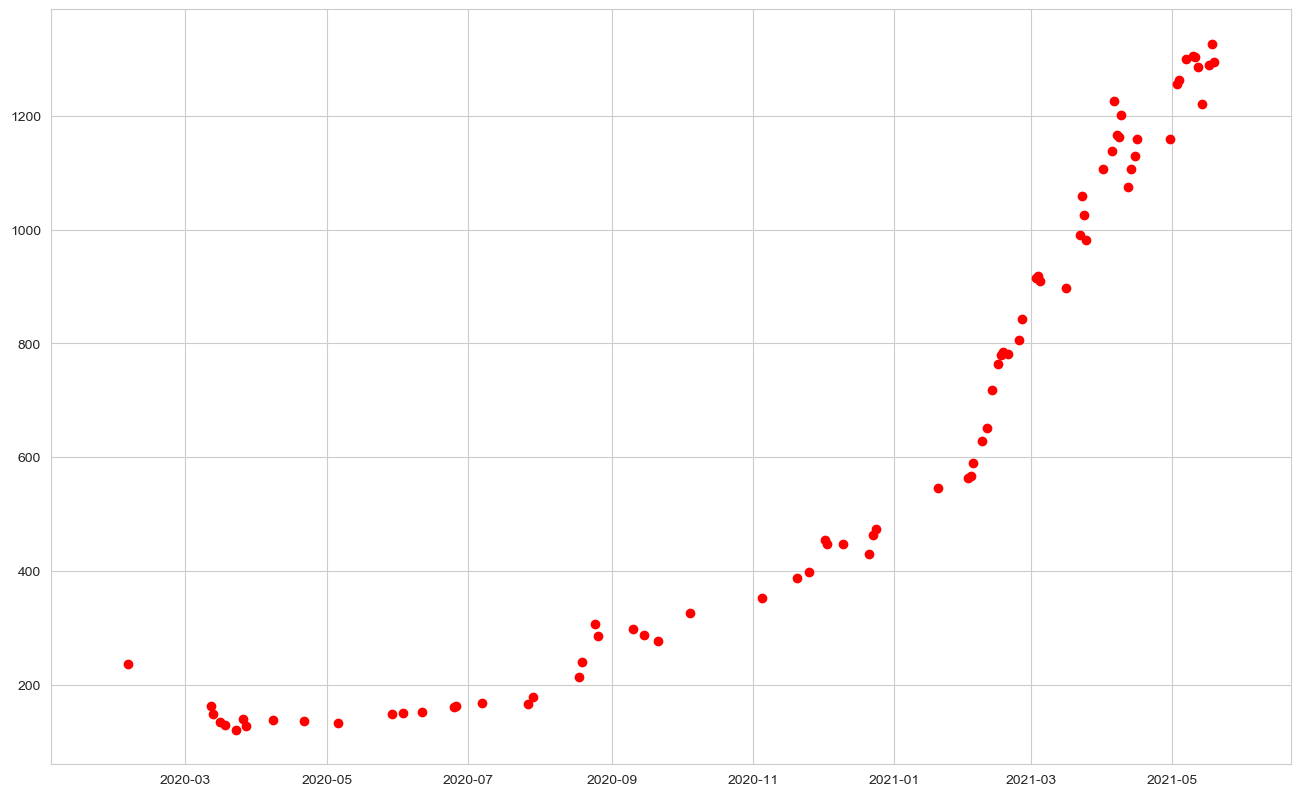

In [155]:
plt.figure(figsize=(16, 10), dpi=100)
plt.scatter(x=dcombined['Date'], y=dcombined['Close_x'], color='r')

In [154]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(dcombined)

         Date      Close_x  Volume_x  Fluctuations_x
0  2020-02-05   236.250000   8985919       16.750000
1  2020-03-12   162.149994   4834390       23.449997
2  2020-03-13   148.750000   7463176       31.600006
3  2020-03-16   134.699997   6582749       13.650009
4  2020-03-18   130.199997   4255688        9.900002
5  2020-03-23   120.900002   1456143       16.800003
6  2020-03-26   140.250000   7980255       19.949997
7  2020-03-27   128.000000   4378366       24.750000
8  2020-04-08   138.100006   3237290       12.250000
9  2020-04-21   135.949997   3576177        8.850006
10 2020-05-06   133.250000   6685480        8.099991
11 2020-05-29   148.350006   9162612       12.500000
12 2020-06-03   150.649994   5875845        8.299988
13 2020-06-11   151.800003  16533100       15.199997
14 2020-06-25   161.649994  14608370       16.199997
15 2020-06-26   162.149994   6772909        5.050003
16 2020-07-07   168.149994   8172143        7.349991
17 2020-07-27   165.949997   1156539        6.

In [173]:
dcombined['Anomaly'] = 1
dcombined.head()

,Date,Close_x,Volume_x,Fluctuations_x,Change_wrt_market_x,Anomaly
0,2020-02-05,236.250000,8985919,16.750000,5.240873,1
1,2020-03-12,162.149994,4834390,23.449997,2.067560,1
2,2020-03-13,148.750000,7463176,31.600006,-2.171006,1
3,2020-03-16,134.699997,6582749,13.650009,1.240838,1
4,2020-03-18,130.199997,4255688,9.900002,0.431714,1


In [163]:
Base_url = 'https://www.moneycontrol.com/'
List_of_links=[]
all_dates=[]
final_all_dates = []
all_news = []
all_headlines = []
all_time=[]
for i in range(2020,2022):
    for j in range(1,10):
        time2=[]
        html = requests.get('https://www.moneycontrol.com/stocks/company_info/stock_news.php?sc_id=AE01&scat=&pageno='+str(j)+'&next=0&durationType=Y&Year='+str(i)+'&duration=1&news_type=')
        soup = BeautifulSoup(html.text,'html.parser')
        sub_links = soup.find_all('a', class_='arial11_summ')
        if not sub_links:
            break;
        dates = soup.find_all('p', class_='PT3 a_10dgry')
        dates = str(dates)
        time1 = re.findall('([1-9]|1[0-2])(.[0-5][0-9][\s][am|pm])', dates)
        dates = re.findall('[0-9o/]{2}[\s][A-Z]{1}[a-z]{2}[\s][0-9O/]{4}[\s]', dates)
        dates = [x[:-1] for x in dates]
        all_dates.extend(dates)
        for k in range(0, len(time1)):
            if k % 2:
                continue
            else :
                time2.append(time1[k][0]+time1[k][1]+'m')
        print(time2)
        all_time.extend(time2)
        for links in sub_links:
            sp = BeautifulSoup(str(links),'html.parser')  
            tag = sp.a
            category_links = Base_url + tag["href"]
            List_of_links.append(category_links)
            
for links in List_of_links:
    html = requests.get(links)
    soup = BeautifulSoup(html.text,'html.parser')
    Headlines = soup.find_all('title')
    Headlines = str(Headlines)
    Headlines = Headlines.strip("[<title>")
    Headlines = Headlines.strip("/title>]")
    Headlines = Headlines[ : -1]
    all_headlines.append(Headlines)
    if soup.find('div',{'class':'arti-flow'}):
        news_text = soup.find('div',{'class':'arti-flow'})
    for x in news_text.find_all("script"):
        x.decompose()
    for y in news_text.find_all('style'):
        y.decompose()
    news_text.find_all('a')[-1].decompose()
    news = news_text.text
    news = news[news.find('More'):]
    news = news.split(' ', 2)[2]
    news = news.split(' ', 1)[1]
    news = news.split(' ', 1)[1]
    all_news.append(news)
    
for i in range(len(all_dates)):
    date = all_dates[i].split(" ")
    month = {'Jan':'01','Feb':'02','Mar':'03','Apr':'04','May':'05','Jun':'06','Jul':'07','Aug':'08','Sep':'09','Oct':'10',
             'Nov':'11','Dec':'12' }
    date[1] = month[date[1]]
    date.reverse()
    date = '-'.join(date)
    date = datetime.strptime(date, '%Y-%m-%d').date()
    final_all_dates.append(date)
    
dfn = pd.DataFrame()
dfn = pd.DataFrame(list(zip(all_time,final_all_dates, all_headlines, all_news)), columns =['Time','Date', 'Headlines', 'News'])

['9.00 am', '4.22 pm', '9.04 pm', '6.40 pm', '4.41 pm', '9.08 am', '9.34 pm', '7.56 am', '9.08 am', '7.30 pm', '4.28 pm', '3.01 pm', '2.53 pm', '8.10 pm', '9.28 pm', '11.40 am', '5.20 pm', '11.30 am', '7.56 pm']
['7.39 am', '12.40 pm', '10.11 am', '9.33 am', '7.33 pm', '7.33 pm']
['2.09 pm', '10.39 am', '11.16 am', '10.38 am', '9.54 am', '10.11 am', '4.56 pm', '3.48 pm']


In [6]:
dfn.head()

,Time,Date,Headlines,News
0,9.00 am,2020-11-06,Adani Enterpris Standalone September 2020 Net ...,Reported Standalone quarterly numbers for Ada...
1,4.22 pm,2020-11-05,Adani Enterpris Consolidated September 2020 Ne...,Reported Consolidated quarterly numbers for A...
2,9.04 pm,2020-11-04,"Adani Enterprises To Invest Rs 50,000 Crore On...",Adani Group's flagship firm Adani Enterprises...
3,6.40 pm,2020-11-04,Adani Enterprises Posts Rs 436 Crore Quarterly...,"Turning profitable in the September quarter, ..."
4,4.41 pm,2020-08-25,Kerala HC Refuses To Stay Privatisation Of Thi...,The Kerala High Court on Tuesday declined to ...


In [164]:
dfn.shape

(33, 4)

In [174]:
dfn['Date'] = pd.to_datetime(dfn['Date'])
dff = pd.merge(df, dfn, on='Date', how='outer')
dff = pd.merge(dff, dcombined, on='Date', how='outer')
dff.sort_values(by='Date', inplace=True)
dff.drop(['Daily Log Returns','Close_x', 'Volume_x', 'Fluctuations_x','ema21_Fluctuations','ema21_Volume',
         'ma7_Close', 'ema21_Close'],axis=1,inplace=True)

In [178]:
dff.to_csv('Adani_Enterprises.csv')